In [1]:
from utils_bert import train, validate
from mfae.model_visual import ESIM
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
import argparse
import json
import numpy as np
import pickle
import torch
import matplotlib
from bert_serving.client import BertClient
matplotlib.use('Agg')
device = 'cpu'

In [50]:
def transform_batch_data(data, batch_size=64, shuffle=True):
    data_batch = dict()
    data_batch['premises'] = dict()
    data_batch['hypotheses'] = dict()
    data_batch['labels'] = dict()
    index = np.arange(len(data['labels']))
    if shuffle:
        np.random.shuffle(index)

    idx = -1
    for i in range(len(index)):
        if i % batch_size == 0:
            idx += 1
            data_batch['premises'][idx] = []
            data_batch['hypotheses'][idx] = []
            data_batch['labels'][idx] = []
        data_batch['premises'][idx].append(data['premises'][index[i]])
        data_batch['hypotheses'][idx].append(data['hypotheses'][index[i]])
        data_batch['labels'][idx].append(int(data['labels'][index[i]]))
    return data_batch

def plt_attention(A, xticks, yticks, fig_name):
    """ Generates a heat map for the attention matrix.
    
        Args:
            A: torch.Tensor of shape (batch_size, 1, max_length, max_length)
                The attention matrix.
            xticks: list of string
                The labels to use for the x-axis ticks.
            yticks: list of string
                The labels to use for the y-axis ticks.
                
        Returns:
            None
    """
    A = A[1:-1,1:-1]
    xticks = [w for w in xticks[0].rstrip().split()]
    yticks = [w for w in yticks[0].rstrip().split()]
#     print(A.shape, len(xticks), len(yticks))
    # Sanity checks
    assert(A.shape[0] == len(xticks) and A.shape[1] == len(yticks))
    
    # Make plot bigger so its easier to read
    plt.rcParams["figure.figsize"] = 10, 10
    
    # Make x-ticks and label appear on top
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    
    # Plot the attention distribution
#     plt.matshow(A)
    plt.imshow(A, cmap="rainbow", interpolation="nearest")
    plt.yticks(range(len(xticks)), xticks)
    plt.xticks(range(len(yticks)), yticks, rotation=90)
    plt.colorbar()
    plt.savefig(fig_name, dpi=300)    
    plt.show()
    
def plt_importance(intra_importance, inter_importance, yticks, fig_name):
    """ Generates heat maps for the importance matrix.
    
        Args:
            A: torch.Tensor of shape (batch_size, 1, max_length, max_length)
                The attention matrix.
            xticks: list of string
                The labels to use for the x-axis ticks.
            yticks: list of string
                The labels to use for the y-axis ticks.
                
        Returns:
            None
    """
    intra_importance = intra_importance[1:-1]
    inter_importance = inter_importance[1:-1]
    yticks = [w for w in yticks[0].rstrip().split()]

    # Make plot bigger so its easier to read
    plt.rcParams["figure.figsize"] = 10, 10
    
    # Make x-ticks and label appear on top
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    
    # Plot the attention distribution
    plt.subplot(1,3,1)
    plt.imshow(intra_importance, cmap="rainbow", interpolation="nearest")
    plt.yticks(range(len(yticks)), yticks)
    plt.xlabel('Intra Asking Emphasis')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(inter_importance, cmap="rainbow", interpolation="nearest")
    plt.yticks(range(len(yticks)), yticks)
    plt.xlabel('Inter Asking Emphasis')
    plt.colorbar()
    plt.savefig(fig_name, dpi=300)   
    plt.show()

In [3]:
valid_file = 'data/preprocessed/quora/bert_dev_data.pkl'
print("\t* Loading validation data...")
with open(valid_file, "rb") as pkl:
    valid_data = pickle.load(pkl)
    valid_dataloader = transform_batch_data(valid_data, batch_size=1, shuffle=False)

	* Loading validation data...


In [4]:
with open("config/training/quora_training_bert.json", 'r') as config_file:
    config = json.load(config_file)
embedding_size = config["embedding_size"]
hidden_size = config["hidden_size"]
dropout = config["dropout"]
num_classes = config["num_classes"]

In [5]:
checkpoint = 'data/checkpoints/quora/bert/' +"best.pth.tar"
print("\t* Building model...")
model = ESIM(embedding_size,
             hidden_size,
             dropout=dropout,
             num_classes=num_classes,
             device=device).to(device)
checkpoint = torch.load(checkpoint)
model.load_state_dict(checkpoint["model"])

	* Building model...


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
model.eval()
running_loss = 0.0
running_accuracy = 0.0
total_num = 0
bc = BertClient()
batch = valid_dataloader

In [7]:
batch_index = 0
with torch.no_grad():
    # Move input and output data to the GPU if one is used.
    premises = torch.tensor(bc.encode(batch["premises"][batch_index])).to(device)
    hypotheses = torch.tensor(bc.encode(batch["hypotheses"][batch_index])).to(device)
    labels = torch.tensor(batch["labels"][batch_index]).to(device)
    logits, probs, importances = model(premises, hypotheses)
    
    print(batch["premises"][batch_index])
    print(batch["hypotheses"][batch_index])
    print('true class: %d, predict class: %d' % (labels.item(), torch.argmax(probs).item()))

['how do i get funding for my web based startup idea ?']
['how do i get seed funding pre product ?']
true class: 1, predict class: 1


/home/qifeiz/anaconda3/lib/python3.6/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


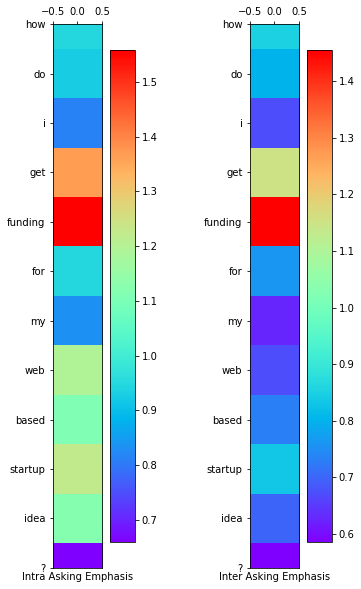

In [51]:
plt_importance(importances[1][0], importances[3][0] , batch["premises"][batch_index], fig_name='sentence1_emphasis')

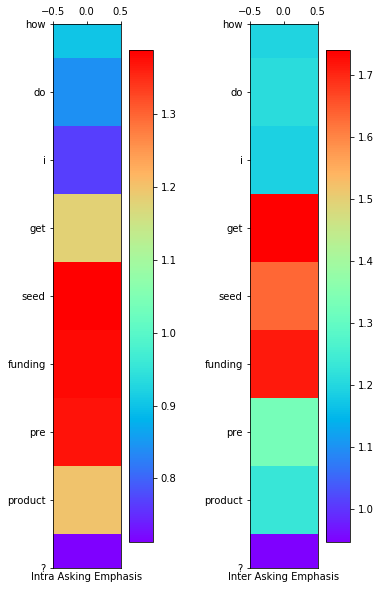

In [52]:
plt_importance(importances[2][0], importances[4][0] , batch["hypotheses"][batch_index], fig_name='sentence2_emphasis')

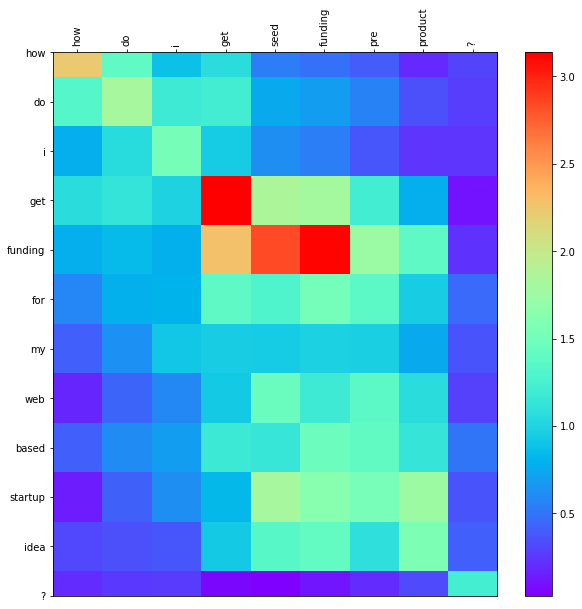

In [53]:
plt_attention(importances[0].cpu().numpy()[0], batch["premises"][batch_index], batch["hypotheses"][batch_index], fig_name='attention')